In [1]:
# https://en.m.wikipedia.org/wiki/List_of_majority-minority_United_States_congressional_districts
state = 'CA'    # 2-letter state code
level = 'tract' # county, tract, block

In [2]:
filepath = 'C:\\districting-data-2020\\'
filename = state + '_' + level + '.json'

# GerryChain has a built-in function for reading graphs of this type:
from gerrychain import Graph
G = Graph.from_json( filepath + filename )

for node in G.nodes:
    # See http://starr.tamu.edu/files/2013/01/Census-Codes.pdf
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']
    
    # Asian alone:
    G.nodes[node]['ASIPOP'] = G.nodes[node]['P0010006']

C:\Users\buchanan\Anaconda3\lib\site-packages\gerrychain\graph\graph.py:239: UserWarning: Found islands (degree-0 nodes). Indices of islands: {1212}
  "Found islands (degree-0 nodes). Indices of islands: {}".format(islands)


In [3]:
# Let's impose a 1% population deviation (+/-0.5%)
deviation = 0.01
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes )

import math
from number_of_districts import congressional_districts_2020
k = congressional_districts_2020[state]
L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 756549 and U = 764152 and k = 52


In [4]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

import networkx as nx
DG = nx.DiGraph(G)   # directed version of G

# create variables
# x[i] equals one when county i is selected
x = m.addVars(G.nodes, vtype=GRB.BINARY)  

# y[u,v] equals one when arc (u,v) is cut because u but not v is selected
y = m.addVars(DG.edges, vtype=GRB.BINARY) 

# z is inverse Polsby-Popper score for district 
z = m.addVar()

# A = area of district 
A = m.addVar()

# P = perimeter of district 
P = m.addVar()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-01


In [5]:
# objective is to minimize inverse Polsby-Popper score
m.setObjective( z, GRB.MINIMIZE )

In [6]:
# add SOCP constraints relating inverse Polsby-Popper score z to area and perimeter
m.addConstr( P * P <= 4 * math.pi * A * z )

# add constraint on area A 
m.addConstr( A == gp.quicksum( G.nodes[i]['area'] * x[i] for i in G.nodes ) )

# add constraint on perimeter P
m.addConstr( P == gp.quicksum( DG.edges[u,v]['shared_perim'] * y[u,v] for u,v in DG.edges )
             + gp.quicksum( G.nodes[i]['boundary_perim'] * x[i] for i in G.nodes if G.nodes[i]['boundary_node'] ) )
    
m.update()

In [7]:
# add constraints saying that district has population at least L and at most U
m.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i] for i in G.nodes) >= L )
m.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i] for i in G.nodes) <= U )

# add constraints saying that arc (u,v) is cut if u but not v is selected
m.addConstrs( x[u] - x[v] <= y[u,v] for u,v in DG.edges )

m.update()

In [8]:
# # Now, let's add contiguity constraints and re-solve the model.
# # We will use the contiguity constraints of Hojny et al. (MPC, 2021)
# #   https://link.springer.com/article/10.1007/s12532-020-00186-3

# # Add root variables: r[i,j] equals 1 if node i is the "root" of district j
# r = m.addVars( G.nodes, k, vtype=GRB.BINARY)

# # To solve the MIP faster, fix a district root:
# r[0,0].LB = 1

# # Add flow variables: f[u,v] = amount of flow sent across arc uv 
# #  Flows are sent across arcs of the directed version of G which we call DG

# f = m.addVars( DG.edges )

In [9]:
# # The big-M proposed by Hojny et al.
# M = G.number_of_nodes() - k + 1

# # Each district j should have one root
# m.addConstrs( gp.quicksum( r[i,j] for i in G.nodes ) == 1 for j in range(k) )

# # If node i is not assigned to district j, then it cannot be its root
# m.addConstrs( r[i,j] <= x[i,j] for i in G.nodes for j in range(k) ) 

# # if not a root, consume some flow.
# # if a root, only send out (so much) flow.
# m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) ) 
#              >= 1 - M * gp.quicksum( r[i,j] for j in range(k) ) for i in G.nodes )

# # do not send flow across cut edges
# m.addConstrs( f[u,v] + f[v,u] <= M * ( 1 - gp.quicksum( y[u,v,j] for j in range(k) ) ) for u,v in DG.edges )

# m.update()

In [10]:
# hispanic_or_latino_population >= 0.5 * total_population
asian_pop = m.addVar()
total_pop = m.addVar()

m.addConstr( asian_pop == gp.quicksum( G.nodes[i]['ASIPOP'] * x[i] for i in G.nodes ) )
m.addConstr( total_pop == gp.quicksum( G.nodes[i]['TOTPOP'] * x[i] for i in G.nodes ) )

m.addConstr( asian_pop >= 0.5 * total_pop )

<gurobi.Constr *Awaiting Model Update*>

In [11]:
# solve IP model
m.Params.TimeLimit = 600
m.optimize()

Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 49959 rows, 59086 columns and 245378 nonzeros
Model fingerprint: 0x13dc1ace
Model has 1 quadratic constraint
Variable types: 5 continuous, 59081 integer (59081 binary)
Coefficient statistics:
  Matrix range     [2e-06, 4e+04]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e+05, 8e+05]
Presolve removed 2 rows and 0 columns
Presolve time: 0.25s
Presolved: 49957 rows, 59086 columns, 227184 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 3 continuous, 59083 integer (59081 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 0.000000e+00, 10 iterations, 0.12 seconds (0.06 work unit

In [12]:
print("The inverse PP score is",m.objval)
print("The PP score is",1.0/m.objval)

# retrieve the districts and their populations
district = [i for i in G.nodes if x[i].x > 0.5] 
#district_counties = [ G.nodes[i]["NAME20"] for i in district ] 
district_population = sum(G.nodes[i]["TOTPOP"] for i in district )

# print district info
#print("District has population",district_population,"and contains counties",district_counties)

The inverse PP score is 1.8878463012476496
The PP score is 0.5297041392295098


In [13]:
print("asian_pop =", round(asian_pop.x) )
print("total_pop =", round(total_pop.x) )
print("percentage =", round( 100 * asian_pop.x / total_pop.x ),"%" )

asian_pop = 382027
total_pop = 760703
percentage = 50 %


In [14]:
# Let's draw it on a map
import geopandas as gpd

In [15]:
# Read county shapefile from "<state>_county.shp"
filename = state + '_' + level + '.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

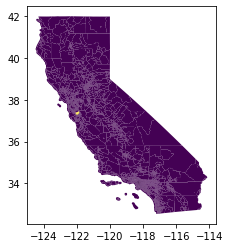

In [16]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling = { i : 1 if x[i].x > 0.5 else 0 for i in G.nodes }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()